In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import time
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)
import jax
import jax.numpy as jnp

import numpy as np
from typing import Sequence
from functools import reduce
from jax.tree_util import tree_map, tree_flatten, tree_unflatten
import flax.linen as nn
from flax.core import freeze, unfreeze

from data import datasets
import visualization

rng_key = jax.random.PRNGKey(0)
print(jax.local_device_count())

1


In [2]:
# load data

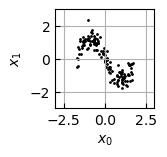

In [3]:
data_key, split_key = jax.random.split(rng_key)
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=data_key, x_lower=0.0, x_upper=6.0)
#dataset = datasets.Izmailov(normalization="standardization")
dataset_train, dataset_validate = dataset.split(split_key, 0.9)
X_train, y_train = dataset_train[:]
figure = visualization.TriangleFigure(prefix="x", settings=visualization.TriangleSettings(univariate=False))
figure.plot(data=dataset_train.data)

In [4]:
# neural network (flax)

In [5]:
from itertools import permutations

class MLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for i, feature in enumerate(self.features[:-1]):
            x = nn.tanh(nn.Dense(feature, use_bias=True, kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros, name=f"dense_{i}")(x))
        x = nn.Dense(self.features[-1], kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros, name=f"dense_{i + 1}")(x)
        return x
    
    def parameters_size(self, inputs):
        parameters = self.init(jax.random.PRNGKey(0), inputs)
        leaves, treedef = tree_flatten(parameters)
        l = sum([reduce(lambda x, y: x * y, leaf.shape) for leaf in leaves])
        return l
    
    def init_from_vector(self, inputs, parameters_vector):
        parameters = self.init(jax.random.PRNGKey(0), inputs)  # I do not need random behaviour here.
        leaves, treedef = tree_flatten(parameters)
        new_leaves = []
        accumulator = 0
        for leaf in leaves:
            size = reduce(lambda x, y: x * y, [s for s in leaf.shape])
            new_leaves.append(parameters_vector[accumulator:accumulator + size].reshape(leaf.shape))
            accumulator += size
        new_parameters = tree_unflatten(treedef, new_leaves)
        return new_parameters
    
    def apply_from_vector(self, inputs, parameters):
        v = self.init_from_vector(inputs=inputs, parameters_vector=parameters)
        return self.apply(v, inputs)
    
    def parameters_permutations(self, inputs):
        # for FLAX nn models, the cols are permuted in current layer and the rows in the following layer.
        parameters_size = self.parameters_size(inputs)
        parameters = self.init_from_vector(incombinations_with_replacementputs, np.arange(parameters_size))
        layer_names = list(parameters["params"].keys())
        
        for i, layer_name in enumerate(layer_names[:-1]):
            layer_parameters = parameters["params"][layer_name]
            bias = layer_parameters["bias"]
            kernel = layer_parameters["kernel"]
            following_bias = parameters["params"][layer_names[i + 1]]["bias"]
            following_kernel = parameters["params"][layer_names[i + 1]]["kernel"]
            
            col_permutations = np.array(list(permutations(np.arange(bias.shape[0]))))
            p_matrix_inner = np.eye(bias.shape[0])
            test_p = np.array(list(permutations(p_matrix_inner)))
            
            bias_permutations = test_p @ bias
            kernel_permutations = (kernel @ test_p).squeeze()
            following_bias_permutations = np.stack([following_bias] * test_p.shape[0], axis=0)  # not permuted
            following_kernel_permutations = (test_p @ following_kernel).reshape(-1, reduce(lambda x, y: x * y, following_kernel.shape))
            all_permutations = np.concatenate([bias_permutations, kernel_permutations, following_bias_permutations, following_kernel_permutations], axis=-1)
            
            full_permutations = np.stack([np.arange(parameters_size)] * all_permutations.shape[0], axis=0)
            full_permutations[:, 0:all_permutations.shape[-1]] = all_permutations
            return 0.0
    
    def project_to_constrained_space(self, parameters_vector, inputs):
        parameters_size = self.parameters_size(inputs)
        indices = np.arange(parameters_size)
        indices_parameters = unfreeze(self.init_from_vector(inputs, indices))
        layer_names = list(indices_parameters["params"].keys())
        for i, layer_name in enumerate(layer_names[:-1]):
            layer_parameters = indices_parameters["params"][layer_name]
            next_layer_parameters = indices_parameters["params"][layer_names[i + 1]]
            
            # bias / kernel indices
            bias = layer_parameters["bias"]
            kernel = layer_parameters["kernel"]
            following_kernel = next_layer_parameters["kernel"]
            
            # sort bias by size
            bias_values = parameters_vector[bias]
            sort_indices = np.argsort(bias_values)
            # TODO: Only change first two biases
            
            # generate permutation matrix
            pm = np.eye(sort_indices.shape[0], dtype=np.int)[sort_indices, :].T
            
            # apply permutation matrix / permute weights
            indices_parameters["params"][layer_name]["bias"] = bias @ pm
            indices_parameters["params"][layer_name]["kernel"] = kernel @ pm
            indices_parameters["params"][layer_names[i + 1]]["kernel"] = pm.T @ following_kernel
            
            # sort kernel rows by size
            for j in range(len(kernel)):
                layer_parameters = indices_parameters["params"][layer_name]
                next_layer_parameters = indices_parameters["params"][layer_names[i + 1]]

                # bias / kernel indices
                bias = layer_parameters["bias"]
                kernel = layer_parameters["kernel"]
                following_kernel = next_layer_parameters["kernel"]
            
                kernel_values = parameters_vector[kernel[j]]
                sort_indices = np.argsort(kernel_values)
                # TODO: Only change first two biases
            
                # generate permutation matrix
                pm = np.eye(sort_indices.shape[0], dtype=np.int)[sort_indices, :].T
            
                # apply permutation matrix / permute weights
                indices_parameters["params"][layer_name]["bias"] = bias @ pm
                indices_parameters["params"][layer_name]["kernel"] = kernel @ pm
                indices_parameters["params"][layer_names[i + 1]]["kernel"] = pm.T @ following_kernel
        
        return parameters_vector[np.concatenate(tree_flatten(tree_map(lambda x: x.flatten(), indices_parameters))[0])]
    
    def project_tanh(self, parameters_vector, inputs):
        parameters_size = self.parameters_size(inputs)
        parameters = unfreeze(self.init_from_vector(inputs, parameters_vector))
        layer_names = list(parameters["params"].keys())
        for i, layer_name in enumerate(layer_names[:-1]):
            layer_parameters = parameters["params"][layer_name]
            next_layer_parameters = parameters["params"][layer_names[i + 1]]
            
            # bias / kernel indices
            bias = layer_parameters["bias"]
            kernel = layer_parameters["kernel"]
            following_kernel = next_layer_parameters["kernel"]
            
            # bias negativ?
            #bias_indices = (bias < 0.0) * 1
            # try first weight col
            bias_indices = (kernel[0] < 0.0) * 1
            
            # generate reflection matrix
            rm = np.eye(bias_indices.shape[0], dtype=np.int) - 2 * np.diag(bias_indices)
            
            # apply permutation matrix / permute weights
            parameters["params"][layer_name]["bias"] = bias @ rm
            parameters["params"][layer_name]["kernel"] = kernel @ rm
            parameters["params"][layer_names[i + 1]]["kernel"] = rm @ following_kernel

        return np.concatenate(tree_flatten(tree_map(lambda x: x.flatten(), parameters))[0])

In [6]:
# probabilistic model (numpyro)

In [96]:
def model(transformation, X, y, parameters_size):
    # TODO: Change to multivariate normal actually!!!
    w = numpyro.sample("w", dist.Normal(jnp.zeros(parameters_size), jnp.ones(parameters_size)))
    outputs = transformation(inputs=X, parameters=w)
    #logstd_ll = numpyro.sample("logstd_ll", dist.LogNormal(1.0, 1.0))  # TODO: Try LogNormal
    #std_ll = jnp.exp(logstd_ll)
    
    # we put a prior on the observation noise
    std_ll = numpyro.sample("logstd_ll", dist.Gamma(3.0, 1.0))
    std_ll = 1.0 / jnp.sqrt(std_ll)
    
    # observe data
    with numpyro.plate("data", size=X.shape[0], dim=-2):
        return numpyro.sample("outputs", dist.Normal(outputs, std_ll), obs=y)

In [97]:
# inference algorithm (numpyro)

In [98]:
def infer(model, neural_network, rng_key, X, y):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=1024,
        num_samples=16,
        num_chains=128,
        progress_bar=True
    )
    
    mcmc.run(rng_key, neural_network.apply_from_vector, X, y, neural_network.parameters_size(X_train[0]))
    return mcmc.get_samples()

In [99]:
rng_key, rng_key_ = jax.random.split(rng_key)
neural_network = MLP([3, 1])
samples = infer(model=model, neural_network=neural_network, rng_key=rng_key_, X=X_train, y=y_train)

<ipython-input-98-60a46e87d664>:4: UserWarning: There are not enough devices to run parallel chains: expected 128 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(128)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1040/1040 [00:02<00:00, 449.79it/s, 255 steps of size 1.77e-02. acc. prob=0.93]


In [100]:
# evaluate results

In [101]:
ws_original = samples["w"]
ws = np.array(jax.random.permutation(rng_key, ws_original))
print(ws.shape)

(2048, 10)


In [102]:
#ws_old = np.load("ws_mlp_3_1_izmailov.npy")
#print(ws_old.shape)
#ws_combined = np.concatenate([ws_old, ws], axis=0)
#print(ws_combined.shape)
#np.save("ws_mlp_3_1_izmailov.npy", ws_combined[-6 * 8192:])

In [103]:
# done

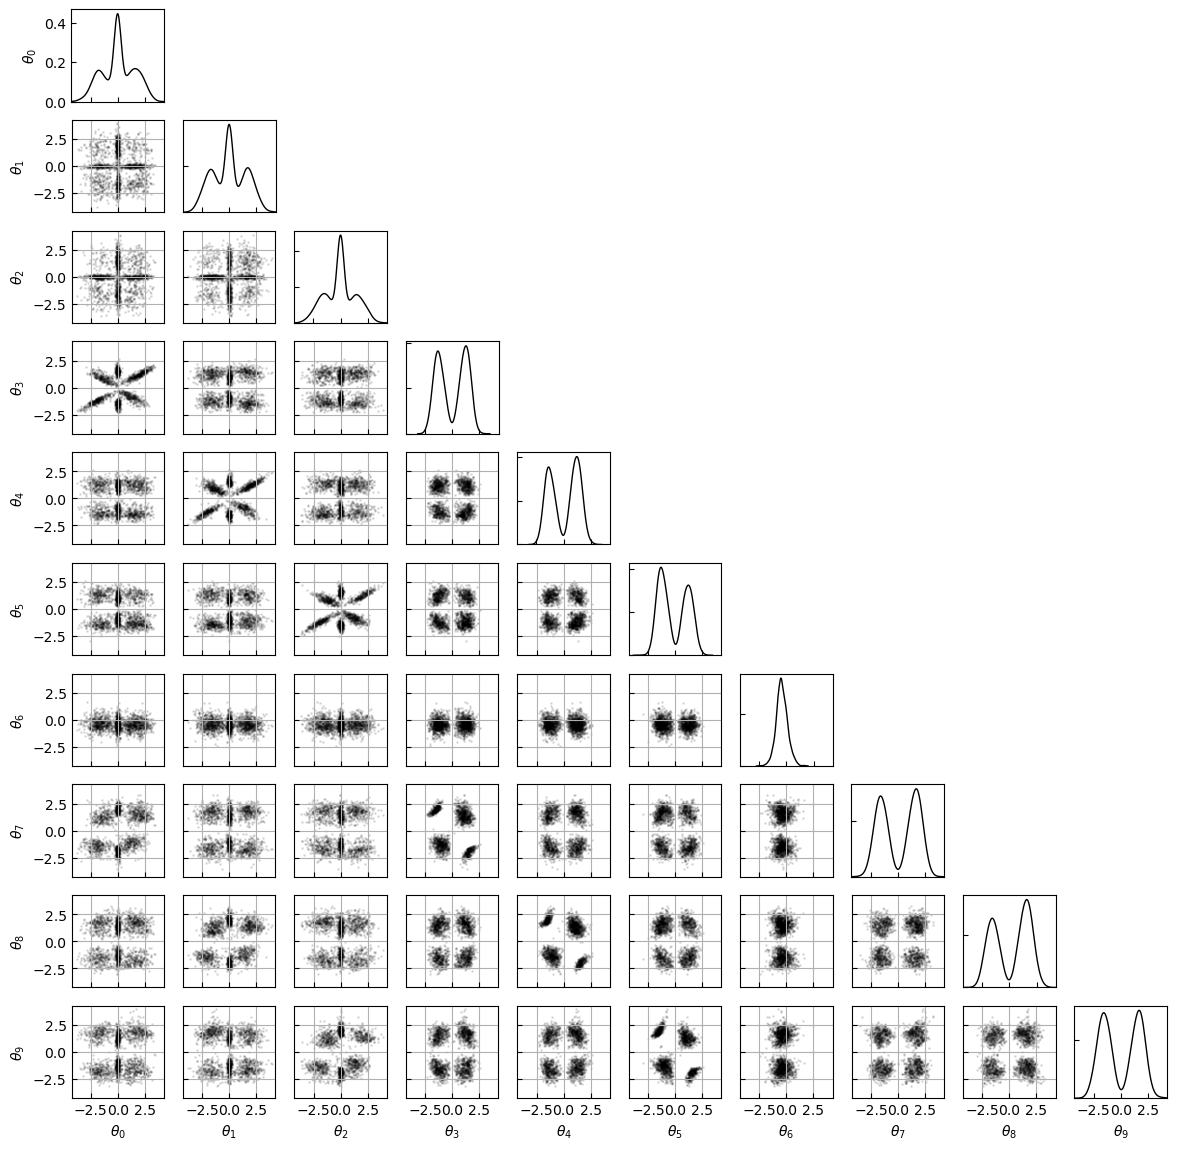

In [104]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.1, size=1.0)
    )
)
figure.plot(data=ws)

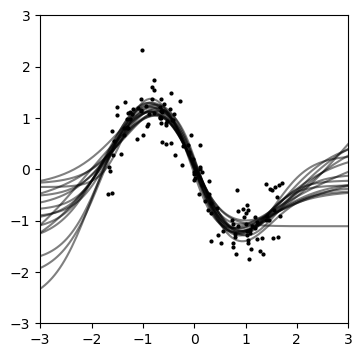

In [105]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.5)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=ws[:16], std=0.1)

In [140]:
# apparently i have to remove tanh symmetries first, then permutation symmetries to obtain a single mode.

ws_constrained = []
for i, w in enumerate(ws[:]):
    w_permuted = w.copy()

    # MLP ([3, 1])
    # tanh symmetries
    if w_permuted[0] < 0.0:
        w_permuted[[0, 3, 7]] *= -1.0
    if w_permuted[1] < 0.0:
        w_permuted[[1, 4, 8]] *= -1.0
    if w_permuted[2] < 0.0:
        w_permuted[[2, 5, 9]] *= -1.0
    
    # permutation symmetries
    biases_1 = w_permuted[0:3]
    kernel_1 = w_permuted[3:6]
    kernel_2 = w_permuted[7:]
    
    biases_1_indices_sort = np.argsort(biases_1.flatten())
    biases_1 = biases_1[biases_1_indices_sort]
    kernel_1 = kernel_1[biases_1_indices_sort]
    kernel_2 = kernel_2[biases_1_indices_sort]
    
    w_permuted[0:3] = biases_1
    w_permuted[3:6] = kernel_1
    w_permuted[7:] = kernel_2
    
    ws_constrained.append(w_permuted)
ws_constrained = np.stack(ws_constrained, axis=0)
#np.save("ws_constrained.npy", ws_constrained)
#ws_constrained = np.load("ws_constrained.npy")

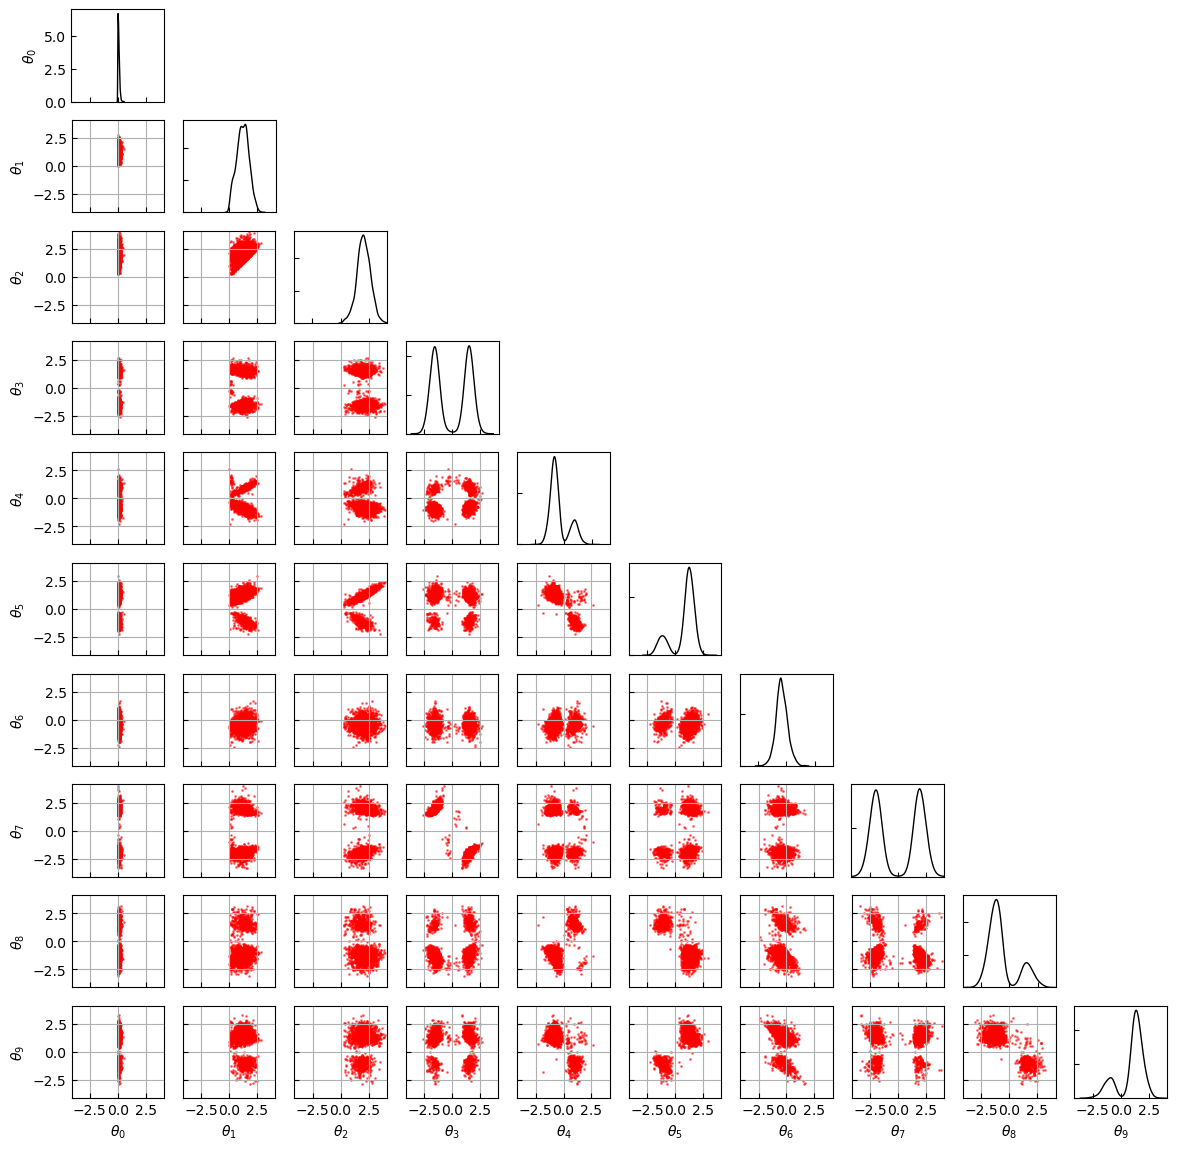

In [141]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=1.0, color="red")
    )
)
figure.plot(data=ws_constrained)

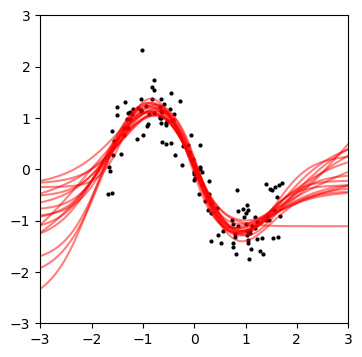

In [142]:
figure = visualization.RegressionFigure(
        settings=visualization.RegressionSettings(
            transformation_plot_settings=visualization.TransformationPlotSettings(color="red", alpha=0.5)
        )
    )
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=ws_constrained[:16], std=0.1)

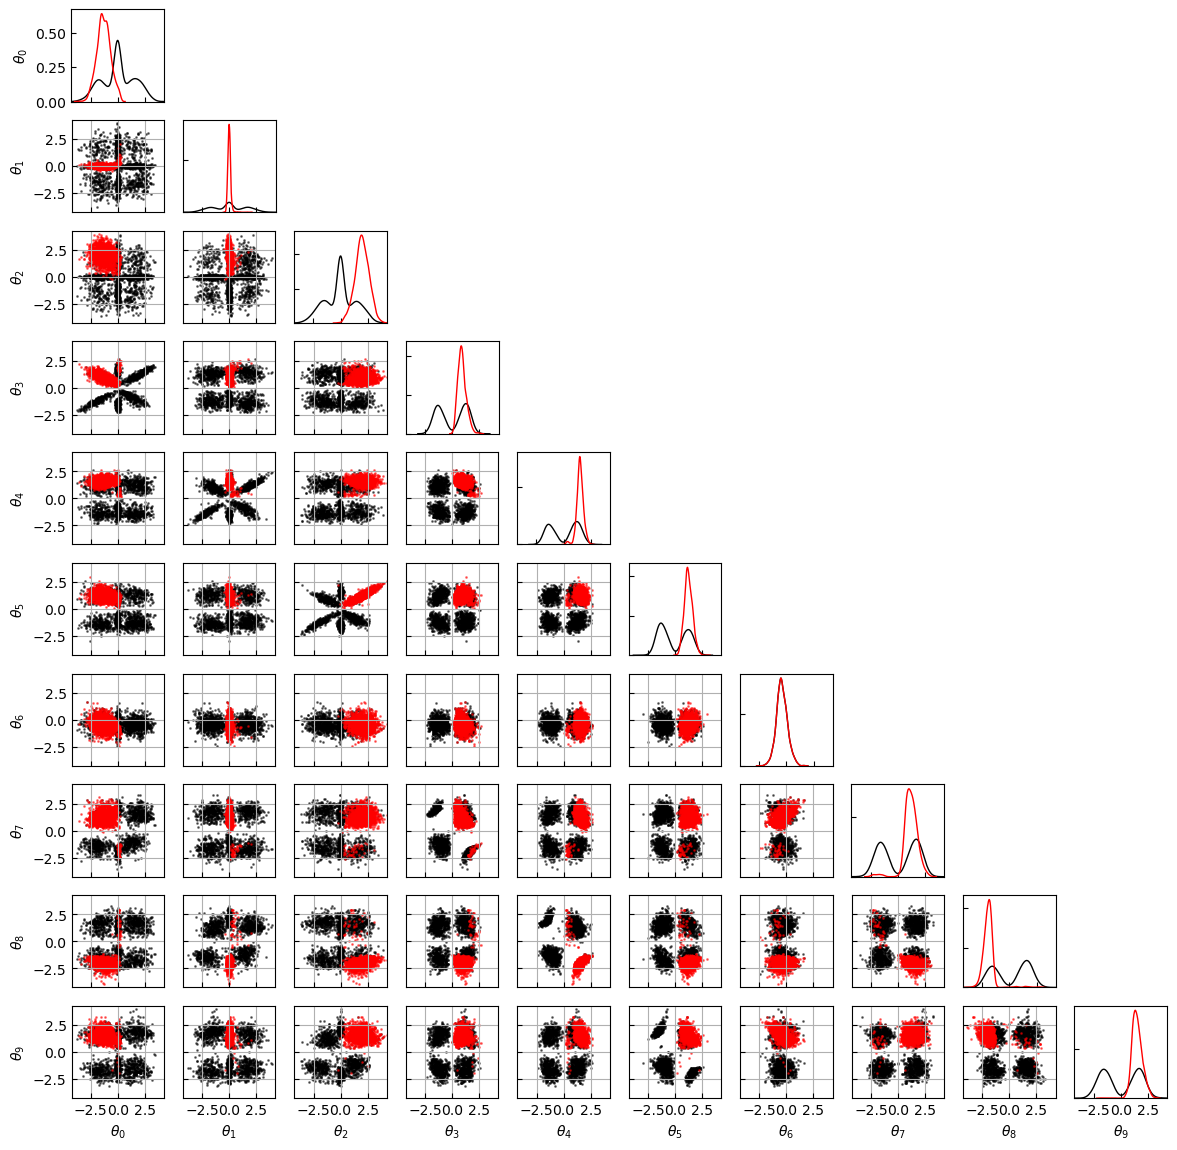

In [109]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=1.0, color="black")
    )
)
figure.plot(data=ws, data_2=ws_constrained)

In [19]:
# now clustering and look for the transformation between the two sets!

In [20]:
selection_1 = np.argwhere((ws_constrained[:, 1] > 0.0) * 1.0).squeeze()
selection_2 = np.argwhere((ws_constrained[:, 1] <= 0.0) * 1.0).squeeze()
set_1 = ws_constrained[selection_1]
set_2 = ws_constrained[selection_2]
print(set_1.shape, set_2.shape)
for i, (ele_1, ele_2) in enumerate(zip(set_1.mean(0), set_2.mean(0))):
    print(i, ele_1, "    ", ele_2)

(4224, 10) (3968, 10)
0 -4.700275      -3.9652414
1 1.2363268      -2.1501133
2 2.709981      1.9983629
3 4.5497637      3.7439501
4 1.4087281      1.6232358
5 1.9364876      3.3366013
6 -0.49486202      0.70204973
7 -0.33933812      -1.7172828
8 2.51953      2.94405
9 -1.291021      1.1248488


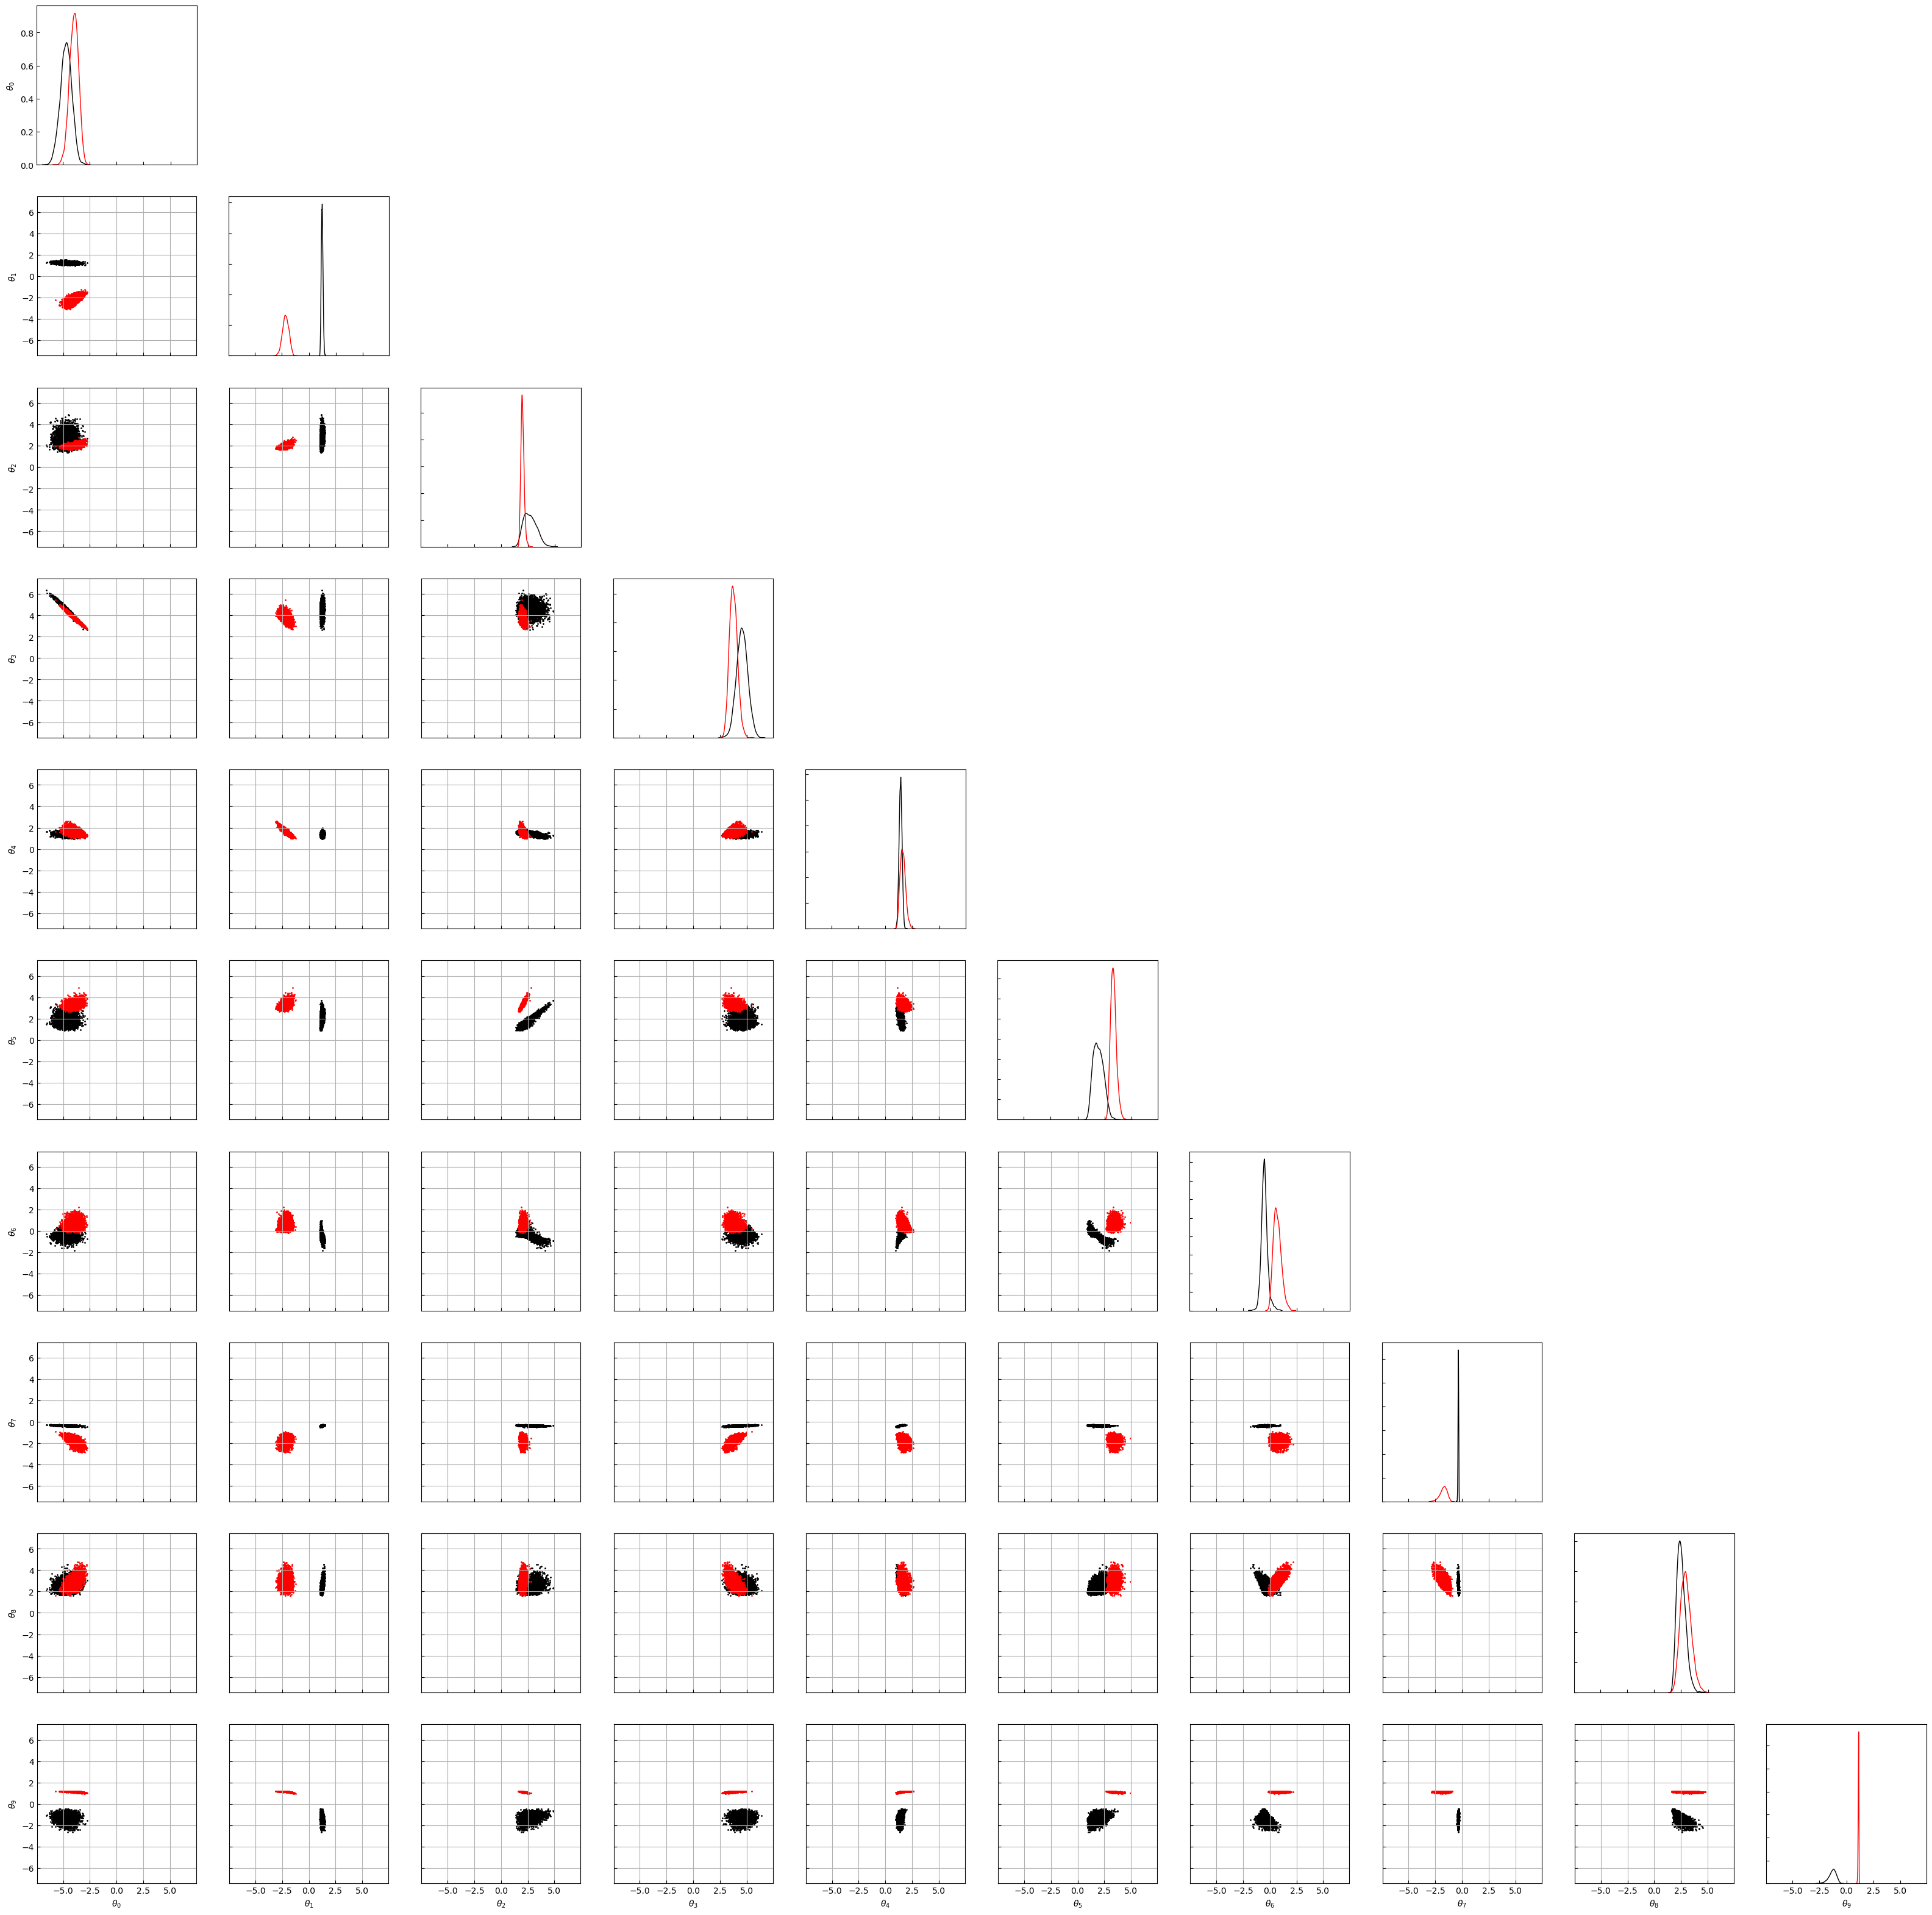

In [21]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=set_1, data_2=set_2)